In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [2]:
df = pd.read_csv("consumer_complaints.csv",encoding='latin-1')

C:\Users\ErandaniD\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [5]:
#selecting required columns and rows 
df = df[['consumer_complaint_narrative']] 
df = df[pd.notnull(df['consumer_complaint_narrative'])]
df.head()

,consumer_complaint_narrative
190126,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Due to inconsistencies in the amount owed that...
190155,In XX/XX/XXXX my wages that I earned at my job...
190207,I have an open and current mortgage with Chase...
190208,XXXX was submitted XX/XX/XXXX. At the time I s...


In [6]:
df.shape

(66806, 1)

In [8]:
#select a sample, as it is easy to interpret
df = df.sample(200)

#### Preprocessing

In [9]:
# Remove unwanted symbol 
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].str.replace('XXXX','').str.replace('XX','')

In [14]:
# Convert dataframe to list 
complaints = df['consumer_complaint_narrative'].tolist() 

In [15]:
# create the rank of documents – will use it later 
ranks = [] 

for i in range(1, len(complaints)+1):    
    ranks.append(i)

##### Stopwords, stemming, and tokenizing

In [10]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

In [11]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

Define two functions:

tokenize_and_stem: tokenizes (splits the text into a list of its respective words (or tokens) and also stems each token)
                              
tokenize_only: tokenizes the text only
                              
Use these functions to create a dictionary which becomes important in case want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. 

In [12]:
# define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [13]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Use above functions to iterate over the list of text to create two vocabularies: one stemmed and one only tokenized.

In [16]:
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in complaints:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these two lists, created a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token.

In [26]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

#### TF-IDF feature engineering

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(complaints) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

C:\Users\ErandaniD\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Wall time: 2.1 s
(200, 36)


In [18]:
#terms is just a list of the features used in the tf-idf matrix. This is a vocabulary
terms = tfidf_vectorizer.get_feature_names()

#### K-means clustering

In [19]:
from sklearn.cluster import KMeans

num_clusters = 6

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 599 ms


In [20]:
#assign the labels as the clusters
clusters = km.labels_.tolist()

In [21]:
#this dictionary to a Pandas DataFrame for easy access
newdf = { 'complaints': complaints, 'rank': ranks, 'cluster': clusters }

df2 = pd.DataFrame(newdf, index = [clusters] , columns = ['complaints','rank', 'cluster'])

In [22]:
df2['cluster'].value_counts() 

4    44
1    43
3    37
0    29
5    24
2    23
Name: cluster, dtype: int64

In [23]:
grouped = df2['rank'].groupby(df2['cluster']) #groupby cluster for aggregation purposes

grouped.mean() #average rank (1 to 100) per cluster

cluster
0    106.620690
1    100.465116
2     96.956522
3     92.675676
4    106.750000
5     97.166667
Name: rank, dtype: float64

#### Identify cluster behavior

In [29]:
#sort cluster centers by proximity to centroid 
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

In [30]:
for i in range(num_clusters):    
    print("Cluster %d words:" % i, end='')  
    for ind in order_centroids[i, :6]:         
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')]. values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')    

    print() 

Cluster 0 words: b'debt', b'company', b'number', b'credit', b'collection', b'contact',
Cluster 1 words: b'reported', b'credit', b'credit', b'information', b'accounts', b'collection',
Cluster 2 words: b'payment', b'months', b'pay', b'times', b'make', b'did',
Cluster 3 words: b'accounts', b'card', b'banking', b'credit', b'did', b'times',
Cluster 4 words: b'banking', b"n't", b'checked', b'times', b'did', b'receive',
Cluster 5 words: b'loan', b'payment', b"n't", b'did', b'company', b'asked',


C:\Users\ErandaniD\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


#### Plot the clusters on a 2D graph

visualize the document clustering output using matplotlib and mpld3 (a matplotlib wrapper for D3.js)

define some dictionaries for cluster number, color, cluster name. The cluster names  will be based on the words that were closest to each cluster centroid.

In [38]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3',  3: '#e7298a', 4: '#66a61e', 5: '#F1C40F'}

#set up cluster names using a dict
cluster_names = {0: 'debt, collection, contact, number',
                 1: 'reported, credit, information' ,
                 2: 'payment, months, times', 
                 3: 'accounts, card, credit',
                 4: 'banking, checked, receive',
                 5: 'loan, payment, asked'
                }

Multidimensional scaling

In [32]:
#Similarity 
from sklearn.metrics.pairwise import cosine_similarity
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

dist is defined as 1 - the cosine similarity of each document. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus. Subtracting it from 1 provides cosine distance which will be used for plotting on a euclidean (2-dimensional) plane.

In [35]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
mds =  MDS(n_components=2, dissimilarity="precomputed",  random_state=1) 
pos =  mds.fit_transform(similarity_distance)  # shape  (n_components, n_samples) 
xs, ys = pos[:, 0], pos[:, 1] 

In [36]:
#Create data frame that has the result of the MDS and the cluster 
df3 = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
groups = df3.groupby('label') 

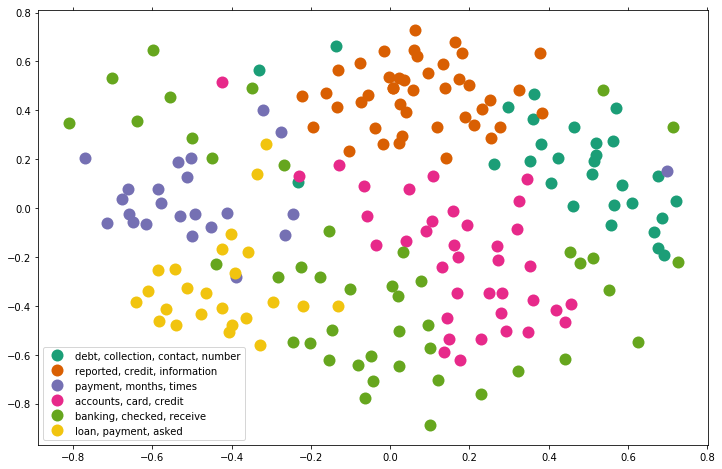

In [39]:
# Set up plot 
fig, ax = plt.subplots(figsize=(12, 8)) # set size 
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,label=cluster_names[name], color=cluster_colors[name],mec='none')
    ax.set_aspect('auto') 
    ax.tick_params(axis= 'x', which='both', bottom='off', top='off',labelbottom='off')
    ax.tick_params(axis= 'y', which='both',left='off', top='off', labelleft='off')
    ax.legend(numpoints=1) 

plt.show()

We have clustered 200 complaints into 6 groups using K-means clustering. It basically clusters similar kinds of complaints to 6 buckets using TF-IDF. 